В каждой строке через пробел перечислены следующие данные:

Время, чч:мм:сс

Идентификатор трека (id)

Широта, градусы с десятичной дробной частью

Долгота, градусы с десятичной дробной частью

Высота, м

Код ответчика

Позывной


In [1]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
bads =  ['BadTracksHackaton1801.txt',
         'BadTracksHackaton2101.txt',
         'BadTracksHackaton2301.txt'
         ]

goods = ['GoodTracksHackaton1801.txt',
         'GoodTracksHackaton2101.txt',
         'GoodTracksHackaton2301.txt']

In [3]:
bad = pd.concat((pd.read_csv(f, sep=' ', names=['time',
                                              'track_id',
                                              'latitude',
                                              'longitude',
                                              'height',
                                              'code',
                                              'name']) for f in bads), ignore_index=True)
bad['seconds'] = pd.to_timedelta(bad['time']).dt.total_seconds().astype(int)


good = pd.concat((pd.read_csv(f, sep=' ', names=['time',
                                              'track_id',
                                              'latitude',
                                              'longitude',
                                              'height',
                                              'code',
                                              'name']) for f in goods), ignore_index=True)
good['seconds'] = pd.to_timedelta(good['time']).dt.total_seconds().astype(int)


In [4]:
bad.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1753454 entries, 0 to 1753453
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1753454 non-null  object 
 1   track_id   1753454 non-null  int64  
 2   latitude   1753454 non-null  float64
 3   longitude  1753454 non-null  float64
 4   height     1753454 non-null  int64  
 5   code       1691187 non-null  float64
 6   name       1536240 non-null  object 
 7   seconds    1753454 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 107.0+ MB


In [5]:
good.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850653 entries, 0 to 1850652
Data columns (total 8 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   time       1850653 non-null  object 
 1   track_id   1850653 non-null  int64  
 2   latitude   1850653 non-null  float64
 3   longitude  1850653 non-null  float64
 4   height     1850653 non-null  int64  
 5   code       1850202 non-null  float64
 6   name       1127100 non-null  object 
 7   seconds    1850653 non-null  int64  
dtypes: float64(3), int64(3), object(2)
memory usage: 113.0+ MB


#### 1207 пропущенных имен самолетов (можем идентифицировать по номеру трека и коду ответчика)

In [8]:
good[good.name.isna()].groupby(['track_id', 'code']).time.count()

track_id  code  
2         6432.0     119
4         4174.0     114
6         1065.0     536
10        3010.0      94
12        2460.0     539
                    ... 
4042      1074.0     483
4049      1075.0     461
4063      1076.0     356
4068      223.0     1820
4081      2402.0     176
Name: time, Length: 1207, dtype: int64

In [10]:
bad[bad.track_id == 1]

,time,track_id,latitude,longitude,height,code,name,seconds
569250,0:00:00,1,64.435651,34.879156,10668,3104.0,AFL1323,0
569251,0:00:01,1,64.432588,34.881281,10668,3104.0,AFL1323,1
569252,0:00:03,1,64.429691,34.883351,10668,3104.0,AFL1323,3
569253,0:00:04,1,64.427090,34.885288,10668,3104.0,AFL1323,4
569254,0:00:05,1,64.424450,34.887155,10668,3104.0,AFL1323,5
...,...,...,...,...,...,...,...,...
571809,1:17:42,1,55.980626,37.458106,488,3104.0,AFL1323,4662
571810,1:17:44,1,55.982487,37.473426,503,3104.0,AFL1323,4664
571811,1:17:52,1,55.976205,37.430291,648,3104.0,AFL1323,4672
571812,1:17:53,1,55.974247,37.417250,655,3104.0,AFL1323,4673


In [43]:
def plot_params(df, track_id, code):
    
    ig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(15,5))

    to_plot = df[(df.track_id == track_id)&(df.code==code)]
    
    i = 0
    cols = ['height', 'longitude', 'latitude']
    for ax in axes.flatten():
        ax.plot(to_plot.drop_duplicates('seconds')
                        .set_index('seconds')
                        .reindex(np.arange(min(to_plot.seconds), max(to_plot.seconds)),fill_value=0)[cols[i]], label=cols[i])
        i+=1
        ax.legend()
        
    

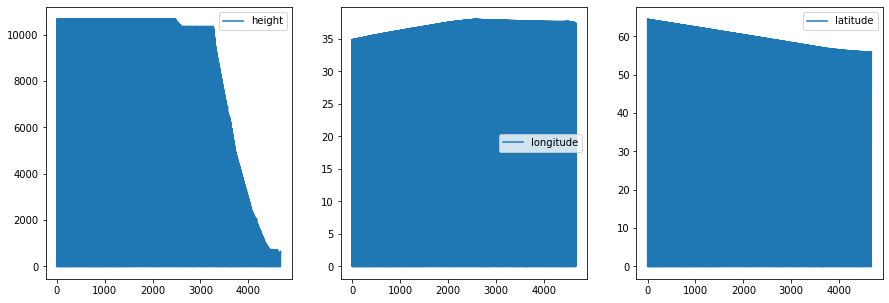

In [44]:
plot_params(bad, 1, 3104)

In [113]:
good = good.sort_values(by=['track_id',  'code', 'name', 'seconds'])

good['group_num'] = good.groupby(['track_id','code', 'name']).cumcount()

good['diff_sec'] = abs(np.where(good.track_id == good.track_id.shift(1), good.seconds.diff(), 0))
good['diff_lat'] = abs(np.where(good.track_id == good.track_id.shift(1), good.latitude.diff(), 0))
good['diff_lon'] = abs(np.where(good.track_id == good.track_id.shift(1), good.longitude.diff(), 0))
good['diff_heig'] = abs(np.where(good.track_id == good.track_id.shift(1), good.height.diff(), 0))
good['heig/sec'] = abs(good['diff_heig']/good['diff_sec'])
good['lon/sec'] = abs(good['diff_lon']/good['diff_sec'])
good['lat/sec'] = abs(good['diff_lat']/good['diff_sec'])
good.replace([np.inf, -np.inf], np.nan, inplace=True) 

good

,time,track_id,latitude,longitude,height,code,name,seconds,diff_sec,diff_lat,diff_lon,diff_heig,heig/sec,lon/sec,lat/sec,group_num
0,0:00:00,1,55.934620,37.272100,1219,1551.0,AFL1522,0,0.0,0.000000,0.000000,0.0,NaN,NaN,NaN,0
1,0:00:03,1,55.933381,37.267583,1219,1551.0,AFL1522,3,3.0,0.001239,0.004517,0.0,0.0,0.001506,0.000413,1
2,0:00:04,1,55.933338,37.266435,1204,1551.0,AFL1522,4,1.0,0.000043,0.001148,15.0,15.0,0.001148,0.000043,2
3,0:00:14,1,55.931407,37.252316,1257,1551.0,AFL1522,14,10.0,0.001931,0.014119,53.0,5.3,0.001412,0.000193,3
4,0:00:24,1,55.933145,37.236722,1303,1551.0,AFL1522,24,10.0,0.001738,0.015594,46.0,4.6,0.001559,0.000174,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1217023,23:59:53,4085,65.416015,37.872759,13716,5753.0,N916MM,86393,1.0,0.002097,0.006942,0.0,0.0,0.006942,0.002097,449
1217024,23:59:55,4085,65.413558,37.864653,13716,5753.0,N916MM,86395,2.0,0.002457,0.008106,0.0,0.0,0.004053,0.001229,450
1217025,23:59:56,4085,65.411820,37.859005,13716,5753.0,N916MM,86396,1.0,0.001738,0.005648,0.0,0.0,0.005648,0.001738,451
1217026,23:59:58,4085,65.409991,37.852927,13716,5753.0,N916MM,86398,2.0,0.001829,0.006078,0.0,0.0,0.003039,0.000915,452


In [167]:
bad[(bad.group_num == 0)&(bad.seconds>1)]

,time,track_id,latitude,longitude,height,code,name,seconds,group_num,diff_sec,diff_lat,diff_lon,diff_heig,heig/sec,lon/sec,lat/sec
1205258,0:00:02,17,54.146816,28.205869,10668,5142.0,AUA75,2,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1205676,0:00:02,21,55.874228,40.185242,10668,2174.0,GZP451,2,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1206059,0:00:03,26,51.163840,40.937027,0,1145.0,BAW259,3,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1206355,0:00:06,31,55.684102,39.759613,8405,1514.0,SBI1163,6,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
576817,0:00:09,32,55.476617,49.106473,10043,2744.0,AFL1898,9,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1193721,22:46:33,4052,54.370539,25.616663,11880,173.0,KLM847,81993,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1194248,23:10:35,4070,56.749830,27.890258,9746,4351.0,UTA389,83435,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1194726,23:16:04,4075,54.372990,25.613621,11270,4506.0,KLM811,83764,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1196767,23:19:17,4077,55.605953,37.152377,1067,1517.0,UTA445,83957,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


#### Очень много пропусков позывных рейса, возможно стоит делить треки по кодам ответчика, те если новый диспетчер/аэропорт/аварийная ситуация  то новый трек  

In [114]:
codes_to_check = [1200,7000,21,22,1,7001,2000,0,
                  7700,7600,7500 ]
good[good.code.isin(codes_to_check)].code.value_counts()


21.0      1111
2000.0     745
1.0        433
22.0       259
7000.0     101
Name: code, dtype: int64

In [115]:
bad[bad.code.isin(codes_to_check)].code.value_counts()


2000.0    6112
7000.0    4570
22.0      1011
1200.0     585
0.0        251
Name: code, dtype: int64

- 1200 - ПВП полеты над Североамериканским воздушным пространством (если не был присвоен другой код).
- 7000 - ПВП полеты над бОльшей частью Европы и России
- 0021 - ПВП полеты над воздушным пространством Германии (5000 футов и ниже)
- 0022 - ПВП полеты над воздушным пространством Германии (выше 5000 футов)
- 0001 - Код для военных высокоскоростных не контролируемых полетов службой УВД (США)
- 7001 - Используется в случае незапланированного пересечения запрещенных высот во время проведения военных учений (Великобритания)
- 2000 - Устанавливается экипажем самостоятельно, если по каким-либо причинам диспетчер не присвоил ВС код
- 0000 - военный экорт (в США)
- 7700 - Основной аварийный код. Этот код говорит о том, что на борту возникла аварийная ситуация.
- 7600 - Выход из строя радио или потеря голосовой связи. Этот код позволяет диспетчерам понять, что на борту технические проблемы с радиосвязью. При этом борт не аварийный и службы движения пытаются установить с бортом резервный канал связи – например сплитом (через другой борт) или посредством световых сигналов.
- 7500 - Код означает – «самолет захвачен».

In [116]:
print(f'Кол-во уникальных треков: {good.track_id.nunique()}\nКол-во уникальных кодов: {good.code.nunique()}')

print(f'Кол-во треков с пропущенными позывными: {good[good.name.isna()].track_id.nunique()} ({good[good.name.isna()].track_id.count()} строк)')

print('Кол-во треков с разрывом больше часа: ', 
     good[(good.diff_sec > 60*60*1)&(~good.name.isna())&(good.group_num>0)].track_id.nunique())

print('Кол-во треков с разрывом больше получаса: ', 
     good[(good.diff_sec > 60*60*1/2)&(~good.name.isna())&(good.group_num>0)].track_id.nunique())

print('Кол-во треков с изменением высоты больше 100 м в сек: ', 
      good[(~good['heig/sec'].isna())&(good['heig/sec']>100)&(~good.name.isna())&(good.group_num>0)].track_id.nunique())

print('Кол-во треков с изменением широты больше 1 градуса в сек: ', 
      good[(~good['lon/sec'].isna())&(good['lon/sec']>=1)&(~good.name.isna())&(good.group_num>0)].track_id.nunique())

print('Кол-во треков с изменением долготы больше 1 градуса в сек: ', 
      good[(~good['lat/sec'].isna())&(good['lat/sec']>=1)&(~good.name.isna())&(good.group_num>0)].track_id.nunique())

print('Кол-во треков с изменением высоты больше 100 м в одну и ту же секунду: ', 
      good[(good['heig/sec'].isna())&(good.seconds>0)&(abs(good.diff_heig>100))&(~good.name.isna())&(good.group_num>0)].track_id.nunique())




Кол-во уникальных треков: 2557
Кол-во уникальных кодов: 1316
Кол-во треков с пропущенными позывными: 1098 (723553 строк)
Кол-во треков с разрывом больше часа:  0
Кол-во треков с разрывом больше получаса:  0
Кол-во треков с изменением высоты больше 100 м в сек:  109
Кол-во треков с изменением широты больше 1 градуса в сек:  0
Кол-во треков с изменением долготы больше 1 градуса в сек:  0
Кол-во треков с изменением высоты больше 100 м в одну и ту же секунду:  19


In [117]:
# пример с изменением высоты больше 100 м в сек:

good[(~good['heig/sec'].isna())&(good['heig/sec']>100)&(~good.name.isna())&(good.group_num>0)]

,time,track_id,latitude,longitude,height,code,name,seconds,diff_sec,diff_lat,diff_lon,diff_heig,heig/sec,lon/sec,lat/sec,group_num
1218188,0:29:29,1,59.693012,30.088838,1394,2705.0,AFL058,1769,1.0,0.000788,0.002570,130.0,130.000000,0.002570,0.000788,1160
5578,0:24:20,12,52.398911,38.173419,11887,4326.0,ART9561,1460,3.0,0.019242,0.016823,320.0,106.666667,0.005608,0.006414,141
1233778,0:36:53,63,59.749811,30.473601,1524,751.0,THY1AZ,2213,1.0,0.001062,0.000140,130.0,130.000000,0.000140,0.001062,65
636044,1:53:49,98,59.757997,29.713399,1394,6460.0,SDM6328,6829,1.0,0.001148,0.001824,153.0,153.000000,0.001824,0.001148,1250
677990,2:37:24,211,59.788241,30.307401,419,754.0,SBI1024,9444,1.0,0.000295,0.002114,419.0,419.000000,0.002114,0.000295,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117590,18:33:26,3577,52.034721,45.422582,6637,4144.0,PBD468,66806,1.0,0.003036,0.007446,122.0,122.000000,0.007446,0.003036,28
1131090,20:34:00,3703,44.817395,39.147184,10150,2730.0,AZO524,74040,1.0,0.007999,0.000847,114.0,114.000000,0.000847,0.007999,491
1190603,21:30:28,3960,55.383679,37.913319,594,1556.0,SBI1079,77428,3.0,0.002033,0.002092,419.0,139.666667,0.000697,0.000678,5
1201281,22:20:16,4017,56.076279,37.475631,7376,1561.0,SDM4204,80416,4.0,0.004587,0.009147,434.0,108.500000,0.002287,0.001147,121


In [118]:
good[(good.track_id == 12)&(good.code==4326.0)&(good.name=='ART9561')&(good.seconds>1420)]

,time,track_id,latitude,longitude,height,code,name,seconds,diff_sec,diff_lat,diff_lon,diff_heig,heig/sec,lon/sec,lat/sec,group_num
5574,0:23:50,12,52.448763,38.135637,11887,4326.0,ART9561,1430,10.0,0.014902,0.022531,7.0,0.700000,0.002253,0.001490,137
5575,0:24:00,12,52.433678,38.157583,11880,4326.0,ART9561,1440,10.0,0.015085,0.021946,7.0,0.700000,0.002195,0.001508,138
5576,0:24:10,12,52.418277,38.179142,11880,4326.0,ART9561,1450,10.0,0.015401,0.021559,0.0,0.000000,0.002156,0.001540,139
5577,0:24:17,12,52.418153,38.156596,11567,4326.0,ART9561,1457,7.0,0.000124,0.022546,313.0,44.714286,0.003221,0.000018,140
5578,0:24:20,12,52.398911,38.173419,11887,4326.0,ART9561,1460,3.0,0.019242,0.016823,320.0,106.666667,0.005608,0.006414,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1:32:52,12,45.366250,42.774678,11887,4326.0,ART9561,5572,10.0,0.021158,0.005643,0.0,0.000000,0.000564,0.002116,558
5996,1:33:02,12,45.346198,42.780553,11887,4326.0,ART9561,5582,10.0,0.020052,0.005875,0.0,0.000000,0.000587,0.002005,559
5997,1:33:12,12,45.326779,42.786942,11887,4326.0,ART9561,5592,10.0,0.019419,0.006389,0.0,0.000000,0.000639,0.001942,560
5998,1:33:19,12,45.312161,42.792231,11887,4326.0,ART9561,5599,7.0,0.014618,0.005289,0.0,0.000000,0.000756,0.002088,561


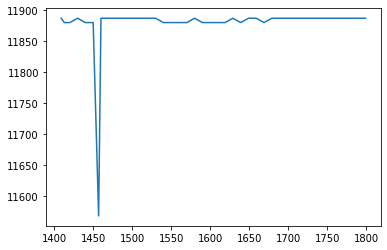

In [163]:
to_plot = good[(good.track_id == 12)&(good.code==4326.0)&(good.name=='ART9561')&(good.seconds>1400)&(good.seconds<1800)]
    

plt.plot(to_plot.seconds, to_plot.height)

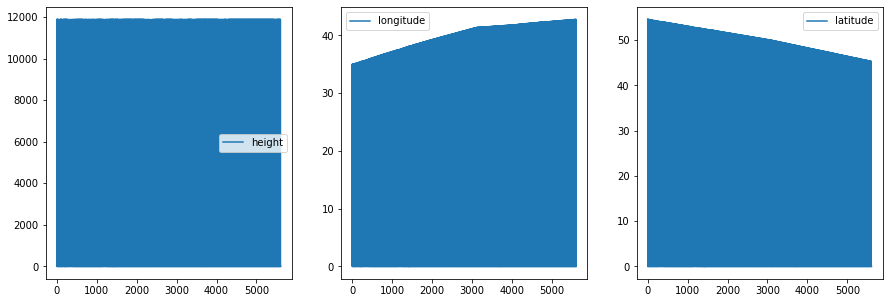

In [120]:
plot_params(good, 12, 4326)

In [121]:
good[(good['heig/sec'].isna())&(good.seconds>0)&(abs(good.diff_heig>100))&(~good.name.isna())&(good.group_num>0)]


,time,track_id,latitude,longitude,height,code,name,seconds,diff_sec,diff_lat,diff_lon,diff_heig,heig/sec,lon/sec,lat/sec,group_num
1329505,6:09:02,460,55.999374,37.419782,2804,5533.0,AFL1407,22142,0.0,0.007451,0.005997,114.0,NaN,NaN,NaN,535
1350054,6:25:45,547,59.765775,29.845739,1394,2110.0,SBI1005,23145,0.0,0.000611,0.001840,130.0,NaN,NaN,NaN,869
192438,7:40:53,1067,55.961947,37.369604,579,2774.0,ABW181,27653,0.0,0.003750,0.016055,396.0,NaN,NaN,NaN,4
215471,9:56:15,1286,55.513648,37.117690,503,1017.0,PBD168,35775,0.0,0.006507,0.028935,236.0,NaN,NaN,NaN,604
1448700,9:43:35,1289,55.979548,37.455166,526,2711.0,SDM6226,35015,0.0,0.002087,0.017703,130.0,NaN,NaN,NaN,317
819724,10:07:19,1457,55.938445,38.173639,5555,5501.0,SDM6258,36439,0.0,0.005890,0.003851,107.0,NaN,NaN,NaN,554
819726,10:07:29,1457,55.936214,38.154445,5448,5501.0,SDM6258,36449,0.0,0.006963,0.004844,122.0,NaN,NaN,NaN,556
819730,10:07:49,1457,55.951476,38.129447,5265,5501.0,SDM6258,36469,0.0,0.005284,0.009800,122.0,NaN,NaN,NaN,560
819732,10:07:59,1457,55.962655,38.118514,5166,5501.0,SDM6258,36479,0.0,0.003836,0.012622,130.0,NaN,NaN,NaN,562
1485034,11:02:15,1587,59.426395,30.605893,3894,2710.0,AFL018,39735,0.0,0.001464,0.002645,350.0,NaN,NaN,NaN,595


In [126]:
good[(good.track_id == 1286)&(good.code==1017.0)&(good.name=='PBD168')&(good.seconds>35700)&(good.seconds<35875)]
    


,time,track_id,latitude,longitude,height,code,name,seconds,diff_sec,diff_lat,diff_lon,diff_heig,heig/sec,lon/sec,lat/sec,group_num
215461,9:55:05,1286,55.490736,37.183903,594,1017.0,PBD168,35705,10.0,0.005691,0.006340,31.0,3.100000,0.000634,0.000569,594
215462,9:55:15,1286,55.496525,37.190067,564,1017.0,PBD168,35715,10.0,0.005789,0.006164,30.0,3.000000,0.000616,0.000579,595
215463,9:55:25,1286,55.502366,37.195389,564,1017.0,PBD168,35725,10.0,0.005841,0.005322,0.0,0.000000,0.000532,0.000584,596
215464,9:55:35,1286,55.508396,37.200083,564,1017.0,PBD168,35735,10.0,0.006030,0.004694,0.0,0.000000,0.000469,0.000603,597
215465,9:55:45,1286,55.514560,37.204369,587,1017.0,PBD168,35745,10.0,0.006164,0.004286,23.0,2.300000,0.000429,0.000616,598
215466,9:55:55,1286,55.520804,37.208462,587,1017.0,PBD168,35755,10.0,0.006244,0.004093,0.0,0.000000,0.000409,0.000624,599
215467,9:55:55,1286,55.521802,37.207877,564,1017.0,PBD168,35755,0.0,0.000998,0.000585,23.0,NaN,NaN,NaN,600
215468,9:56:06,1286,55.527971,37.212630,564,1017.0,PBD168,35766,11.0,0.006169,0.004753,0.0,0.000000,0.000432,0.000561,601
215469,9:56:14,1286,55.514855,37.130790,267,1017.0,PBD168,35774,8.0,0.013116,0.081840,297.0,37.125000,0.010230,0.001640,602
215470,9:56:15,1286,55.507141,37.088755,267,1017.0,PBD168,35775,1.0,0.007714,0.042035,0.0,0.000000,0.042035,0.007714,603


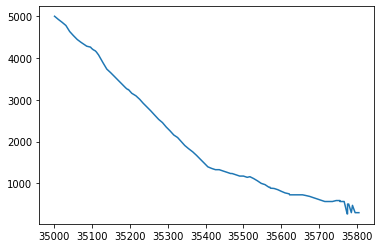

In [162]:
to_plot = good[(good.track_id == 1286)&(good.code==1017.0)&(good.name=='PBD168')&(good.seconds>35000)&(good.seconds<35875)]

plt.plot(to_plot.seconds, to_plot.height)


## распределение перцентилей изменений

In [135]:
good[(~good.name.isna())
     &(good.group_num>0)][['diff_sec', 
                           'diff_heig', 
                           'diff_lat', 
                           'diff_lon']].quantile([.25, .5, 0.75, 0.8, 0.85, 0.9, 0.95,0.99])

,diff_sec,diff_heig,diff_lat,diff_lon
0.25,4.0,0.0,0.002108,0.007248
0.50,10.0,0.0,0.005966,0.015101
0.75,10.0,8.0,0.013641,0.030030
0.80,10.0,30.0,0.015782,0.032321
0.85,10.0,31.0,0.017462,0.034278
0.90,10.0,61.0,0.019017,0.036569
0.95,10.0,91.0,0.020841,0.039814
0.99,20.0,145.0,0.024977,0.067335


In [151]:
good[(~good['heig/sec'].isna())&(~good.name.isna())&(good.group_num>0)][['heig/sec']].quantile([.25, .5, 0.75, 0.9, 0.999])


,heig/sec
0.250,0.0
0.500,0.0
0.750,0.8
0.900,9.0
0.999,45.5


In [152]:
good[(~good['lon/sec'].isna())&(~good.name.isna())&(good.group_num>0)][['lon/sec']].quantile([.25, .5, 0.75, 0.9, 0.999])


,lon/sec
0.250,0.001372
0.500,0.002656
0.750,0.003463
0.900,0.004012
0.999,0.008744


In [153]:
good[(~good['lat/sec'].isna())&(~good.name.isna())&(good.group_num>0)][['lat/sec']].quantile([.25, .5, 0.75, 0.9, 0.999])


,lat/sec
0.250,0.000432
0.500,0.000962
0.750,0.001615
0.900,0.001984
0.999,0.004440


<AxesSubplot:xlabel='heig/sec', ylabel='Count'>

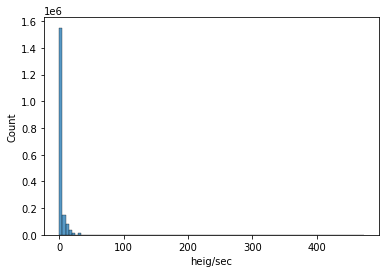

In [143]:
sns.histplot(good['heig/sec'], bins=100)

In [154]:
good[(~good['lon/sec'].isna())&(good['lon/sec']>0.009)&(~good.name.isna())&(good.group_num>0)]

,time,track_id,latitude,longitude,height,code,name,seconds,diff_sec,diff_lat,diff_lon,diff_heig,heig/sec,lon/sec,lat/sec,group_num
2088,0:18:04,5,60.147185,29.295548,10051,164.0,ABW754,1084,1.0,0.000193,0.009055,0.0,0.000000,0.009055,0.000193,647
623624,0:00:50,33,57.487856,48.701089,10668,2130.0,AFL1508,50,1.0,0.000144,0.011077,15.0,15.000000,0.011077,0.000144,5
624123,0:13:45,36,53.379371,30.002391,10356,6240.0,FRH282,825,1.0,0.001309,0.009897,0.0,0.000000,0.009897,0.001309,160
628202,2:04:14,57,52.915333,31.686764,12184,477.0,AFR257,7454,1.0,0.004340,0.010568,0.0,0.000000,0.010568,0.004340,583
628343,0:40:12,58,64.095874,39.855421,11575,5753.0,CBJ429,2412,1.0,0.000317,0.009452,0.0,0.000000,0.009452,0.000317,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215711,23:30:16,4071,55.987127,39.837134,9594,1577.0,AFL1562,84616,1.0,0.007000,0.023716,0.0,0.000000,0.023716,0.007000,128
1215713,23:30:26,4071,55.990775,39.883182,9655,1577.0,AFL1562,84626,1.0,0.005402,0.019929,0.0,0.000000,0.019929,0.005402,130
1216186,23:21:07,4078,55.632856,37.306770,4420,2173.0,UTA445,84067,6.0,0.081561,0.084307,107.0,17.833333,0.014051,0.013594,4
1216397,23:59:55,4078,57.046364,45.002570,10668,2173.0,UTA445,86395,1.0,0.000558,0.011142,0.0,0.000000,0.011142,0.000558,215


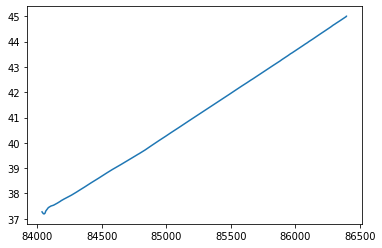

In [161]:
to_plot = good[(good.track_id == 4078)&(good.code==2173.0)&(good.name=='UTA445')&(good.seconds>84000)]

plt.plot(to_plot.seconds, to_plot.longitude)


<AxesSubplot:xlabel='heig/sec', ylabel='Count'>

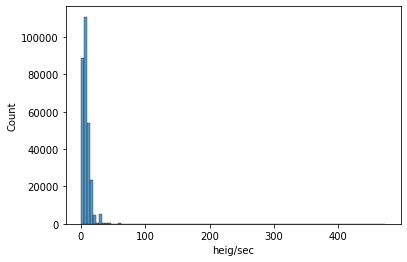

In [147]:
sns.histplot(good[(good['heig/sec']!=np.nan)&(good['heig/sec']>0)&(~good.name.isna())&(good.group_num>0)]['heig/sec'], bins=100)

<AxesSubplot:xlabel='lon/sec', ylabel='Count'>

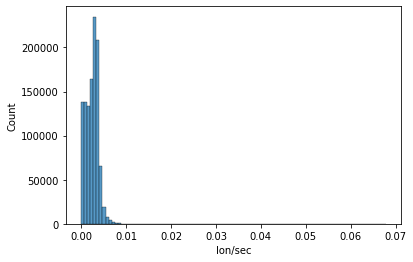

In [148]:
sns.histplot(good[(good['lon/sec']!=np.nan)&(good['lon/sec']>0)&(~good.name.isna())&(good.group_num>0)]['lon/sec'], bins=100)

<AxesSubplot:xlabel='lat/sec', ylabel='Count'>

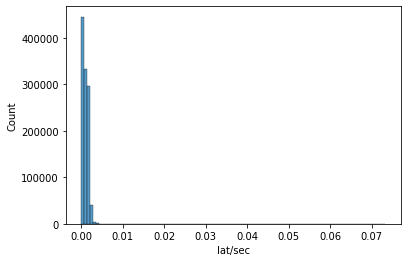

In [149]:
sns.histplot(good[(good['lat/sec']!=np.nan)&(good['lat/sec']>0)&(~good.name.isna())&(good.group_num>0)]['lat/sec'], bins=100)

In [165]:
bad = bad.sort_values(by=['track_id',  'code', 'name', 'seconds'])

bad['group_num'] = bad.groupby(['track_id','code', 'name']).cumcount()

bad['diff_sec'] = abs(np.where(bad.track_id == bad.track_id.shift(1), bad.seconds.diff(), 0))
bad['diff_lat'] = abs(np.where(bad.track_id == bad.track_id.shift(1), bad.latitude.diff(), 0))
bad['diff_lon'] = abs(np.where(bad.track_id == bad.track_id.shift(1), bad.longitude.diff(), 0))
bad['diff_heig'] = abs(np.where(bad.track_id == bad.track_id.shift(1), bad.height.diff(), 0))
bad['heig/sec'] = abs(bad['diff_heig']/bad['diff_sec'])
bad['lon/sec'] = abs(bad['diff_lon']/bad['diff_sec'])
bad['lat/sec'] = abs(bad['diff_lat']/bad['diff_sec'])
bad.replace([np.inf, -np.inf], np.nan, inplace=True) 

bad

,time,track_id,latitude,longitude,height,code,name,seconds,group_num,diff_sec,diff_lat,diff_lon,diff_heig,heig/sec,lon/sec,lat/sec
569250,0:00:00,1,64.435651,34.879156,10668,3104.0,AFL1323,0,0,0.0,0.000000,0.000000,0.0,NaN,NaN,NaN
569251,0:00:01,1,64.432588,34.881281,10668,3104.0,AFL1323,1,1,1.0,0.003063,0.002125,0.0,0.0,0.002125,0.003063
569252,0:00:03,1,64.429691,34.883351,10668,3104.0,AFL1323,3,2,2.0,0.002897,0.002070,0.0,0.0,0.001035,0.001448
569253,0:00:04,1,64.427090,34.885288,10668,3104.0,AFL1323,4,3,1.0,0.002601,0.001937,0.0,0.0,0.001937,0.002601
569254,0:00:05,1,64.424450,34.887155,10668,3104.0,AFL1323,5,4,1.0,0.002640,0.001867,0.0,0.0,0.001867,0.002640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197824,23:59:35,4083,54.089105,35.170493,11567,2163.0,THY6254,86375,129,10.0,0.015675,0.024805,8.0,0.8,0.002481,0.001567
1197825,23:59:45,4083,54.073125,35.146342,11567,2163.0,THY6254,86385,130,10.0,0.015980,0.024151,0.0,0.0,0.002415,0.001598
1197826,23:59:46,4083,54.070475,35.147136,11575,2163.0,THY6254,86386,131,1.0,0.002650,0.000794,8.0,8.0,0.000794,0.002650
1197827,23:59:53,4083,54.059252,35.133789,11575,2163.0,THY6254,86393,132,7.0,0.011223,0.013347,0.0,0.0,0.001907,0.001603


## Анализ для плохих треков

In [166]:
print(f'Кол-во уникальных треков: {bad.track_id.nunique()}\nКол-во уникальных кодов: {bad.code.nunique()}')

print(f'Кол-во треков с пропущенными позывными: {bad[bad.name.isna()].track_id.nunique()} ({bad[bad.name.isna()].track_id.count()} строк)')

print('Кол-во треков с разрывом больше часа: ', 
     bad[(bad.diff_sec > 60*60*1)&(~bad.name.isna())&(bad.group_num>0)].track_id.nunique())

print('Кол-во треков с разрывом больше получаса: ', 
     bad[(bad.diff_sec > 60*60*1/2)&(~bad.name.isna())&(bad.group_num>0)].track_id.nunique())

print('Кол-во треков с изменением высоты больше 100 м в сек: ', 
      bad[(~bad['heig/sec'].isna())&(bad['heig/sec']>100)&(~bad.name.isna())&(bad.group_num>0)].track_id.nunique())

print('Кол-во треков с изменением широты больше 1 градуса в сек: ', 
      bad[(~bad['lon/sec'].isna())&(bad['lon/sec']>=1)&(~bad.name.isna())&(bad.group_num>0)].track_id.nunique())

print('Кол-во треков с изменением долготы больше 1 градуса в сек: ', 
      bad[(~bad['lat/sec'].isna())&(bad['lat/sec']>=1)&(~bad.name.isna())&(bad.group_num>0)].track_id.nunique())

print('Кол-во треков с изменением высоты больше 100 м в одну и ту же секунду: ', 
      bad[(bad['heig/sec'].isna())&(bad.seconds>0)&(abs(bad.diff_heig>100))&(~bad.name.isna())&(bad.group_num>0)].track_id.nunique())




Кол-во уникальных треков: 2470
Кол-во уникальных кодов: 1082
Кол-во треков с пропущенными позывными: 379 (217214 строк)
Кол-во треков с разрывом больше часа:  249
Кол-во треков с разрывом больше получаса:  257
Кол-во треков с изменением высоты больше 100 м в сек:  1795
Кол-во треков с изменением широты больше 1 градуса в сек:  1
Кол-во треков с изменением долготы больше 1 градуса в сек:  0
Кол-во треков с изменением высоты больше 100 м в одну и ту же секунду:  445
